In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import utilities # codeTimer context manager and saving/loading utilities.
import data_preparation # Load dataset and build required matrices.
import factorisation # WALS factorisation.
import recommender # Recommender system.

## Loading dataset and creating recommender system

In [3]:
np.random.seed(17)

mov, rat, rat_test = data_preparation.importDataset()
k = 100
rec = recommender.recommenderSystem(mov, rat, rat_test, k)

print("Prediction MAE: {}".format(rec.predictionError()))

The dataframe contains 610 users and 9721 items.
Prediction MAE: 46.3893943883063


A pre-trained recommander system can be loaded using the following cell. The pre-trained system has been trained using the whole dataset with $k = 100$ latent factors and 10 iterations.

In order to save disk space, the saved system consists only of the item and user embedding matrices. This requires the user to call the previous cell, building the remaining components of the system. 

In [4]:
#utilities.loadRecSys(rec, "rec.npz")

## Explorative analysis

In [5]:
np.count_nonzero(rec.R)
sparsity = np.count_nonzero(rec.R)/np.prod(rec.R.shape)
print("Matrix sparsity: {}%".format(sparsity*100))

Matrix sparsity: 1.5976228580679652%


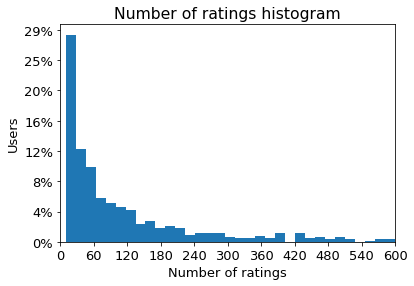

In [6]:
# Distribution of number of ratings.
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 13})

n_ratings = [np.count_nonzero(i) for i in rec.R]


fig, ax = plt.subplots()

ax.hist(n_ratings, bins = 150)

ax.set_title("Number of ratings histogram")
ax.set_ylabel("Users")
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in y_vals/np.shape(rec.R)[0]])
ax.set_xlim(0, 600)
ax.set_xlabel("Number of ratings")
ax.xaxis.set_major_locator(MaxNLocator(integer = True))

plt.savefig("plots/n_ratings.pdf", transparent = True)
plt.show()

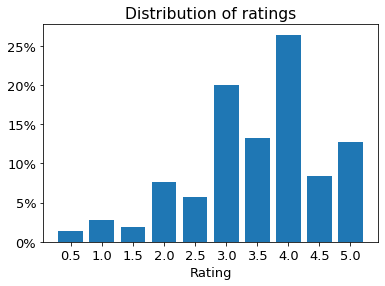

In [7]:
# Counting number ratings.
rates = rec.R.flatten()
rates = rates[rates != 0]
unique, counts = np.unique(rates, return_counts = True)

fig, ax = plt.subplots()
ax.bar(unique, counts / sum(counts), width = 0.4)

ax.set_title("Distribution of ratings")

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in y_vals])

ax.set_xlabel("Rating")
ax.xaxis.set_major_locator(MaxNLocator(integer = False))
plt.rcParams['xtick.labelsize'] = 11
ax.set_xticks(list(unique))

plt.savefig("plots/ratings_dist.pdf", transparent = True)
plt.show()

## Selecting best regression coefficient with CV

Expect ~ 3 hours for the execution of the following cell.

In [ ]:
np.random.seed(17)

reg_lambda = [0.05, 0.15, 0.30]

n_folds = 4
n_iter = 4

# reg_lambda is required to be a list.
with utilities.codeTimer("Best regression lambda CV"):
    best_lambda, errors = rec.bestLambdaCV(n_folds, n_iter, reg_lambda)

In [ ]:
# Plotting results.

fig, ax = plt.subplots()
x = [i + 1 for i in range(n_iter)]
for i in range(len(reg_lambda)):
    ax.plot(x, errors[i][1])

ax.set_title("kFoldCV error")
ax.set_ylabel("MAE")
ax.set_xlabel("Iteration")
ax.xaxis.set_major_locator(MaxNLocator(integer = True))
ax.legend(reg_lambda, title = r"$\lambda$ values")

plt.savefig("plots/TestErrorCV.pdf", transparent = True)
plt.show()

## Factorisation

Expect ~ 50 minutes for the execution of the following cell.

In [ ]:
#reg_lambda = best_lambda
reg_lambda = 0.15
n_iter = 10

with utilities.codeTimer("WALS factorisation"):
    train, test = rec.performFactorisation(reg_lambda, n_iter)

In [ ]:
# Plotting results.
fig, ax = plt.subplots()
x = [i + 1 for i in range(len(test))]
ax.plot(x, test)

ax.set_title("WALS factorisation")
ax.set_ylabel("MAE")
#ax.set_ylim(0, 0.9)
ax.set_xlabel("Iteration")
ax.xaxis.set_major_locator(MaxNLocator(integer = True))

plt.savefig("plots/WALS_train.pdf", transparent = True)
plt.show()

Once the recommander system has been trained, it can be saved to file using the following cell.

In [ ]:
#utilities.saveRecSys(rec, "rec.npz")

## Recommendation

In [8]:
def recommend(rec_system, user_id):
    return rec_system.answerQuery(user_id)
        
def bestRated(rec_system, user_id):
    user_movies = rec_system.getUserMovies(user_id)
    return user_movies.sort_values(by = "Rating", ascending = False)

In [9]:
user_id = 2
recommend(rec, user_id).head(10)

,MovieID,Prediction,Title,Genres,AVG_Rating
2633,2674,3.78,Gladiator (2000),Action|Adventure|Drama,3.909677
480,483,3.55,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical,3.559783
944,957,3.28,"Shining, The (1980)",Horror,4.074766
889,902,2.88,Aliens (1986),Action|Adventure|Horror|Sci-Fi,3.964286
1037,1055,2.60,Star Trek VI: The Undiscovered Country (1991),Action|Mystery|Sci-Fi,3.353659
939,952,2.48,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi|Thriller,3.820000
6115,6242,2.43,Little Miss Sunshine (2006),Adventure|Comedy|Drama,3.847826
913,926,2.39,Amadeus (1984),Drama,4.184211
1418,1438,2.38,Rain Man (1988),Drama,3.781915
2269,2302,2.37,Dogma (1999),Adventure|Comedy|Fantasy,3.614865


In [10]:
bestRated(rec, user_id).head(10)

,MovieID,UserID,Genres,Title,Rating
63308,3734,2,Action|Sci-Fi|Thriller,Hangar 18 (1980),5.0
46993,2141,2,Adventure|Sci-Fi|Thriller,Saturn 3 (1980),5.0
60071,3335,2,Comedy|Horror,The Lair of the White Worm (1988),5.0
54483,2765,2,Action|Adventure|Sci-Fi|Thriller,"Road Warrior, The (Mad Max 2) (1981)",5.0
18806,656,2,Action|Adventure|Sci-Fi|Thriller,Escape from L.A. (1996),5.0
49044,2280,2,Horror|Sci-Fi,Piranha (1978),4.5
31927,1190,2,Action|Adventure|Fantasy,Conan the Barbarian (1982),4.5
40058,1701,2,Action|Horror|Sci-Fi|Thriller,"Thing, The (1982)",4.0
27769,974,2,Action|Adventure|Fantasy,Highlander (1986),3.5
29401,1054,2,Adventure|Sci-Fi,Star Trek: The Motion Picture (1979),3.0


## Similar items
Some suggestions:
* 911: Star Wars Episode VI
* 3638: The Lord of the Rings: The Fellowship of the Ring
* 957: The Shining
* 474: Blade Runner

In [11]:
rec.suggestSimilar(3638)

,MovieID,Title,Genres,Similarity
3638,3638,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,1.000000
4137,4137,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,0.772991
4800,4800,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,0.748294
3568,3568,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,0.748244
659,659,"Godfather, The (1972)",Crime|Drama,0.722716
3194,3194,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,0.721707
4360,4360,Finding Nemo (2003),Adventure|Animation|Children|Comedy,0.691656
277,277,"Shawshank Redemption, The (1994)",Crime|Drama,0.688652
2078,2078,"Sixth Sense, The (1999)",Drama|Horror|Mystery,0.683175
3141,3141,Memento (2000),Mystery|Thriller,0.677524


## Assessing results

The following two cells may take a few minutes to run. By default there are 10 test observations. If this is the case, the mean precision and the mean recall at 10 are expected to be the same.

In [15]:
with utilities.codeTimer("Mean precision"):
    print("Mean precision at 10: {}".format(rec.meanPrecision(10)))

Mean precision at 10: 0.02786885245901636
Executed 'Mean precision'.  Elapsed time: 106.111322s


In [16]:
with utilities.codeTimer("Mean recall"):
    print("Mean recall at 10: {}".format(rec.meanRecall(10)))

Mean recall at 10: 0.02786885245901636
Executed 'Mean recall'.  Elapsed time: 128.173825s


## New user recommendation

In [17]:
np.random.seed(17)

new_user, new_user_id = rec.generateNewUser(50)
np.shape(rec.R)

(610, 9721)

In [18]:
new_user_id
reg_lambda = 0.15

In [19]:
with utilities.codeTimer("New user factorisation"):
    rec.addNewUser(new_user, reg_lambda)
np.shape(rec.R)

Executed 'New user factorisation'.  Elapsed time: 0.636674s


(611, 9721)

In [20]:
recommend(rec, new_user_id).head(10)

,MovieID,Prediction,Title,Genres,AVG_Rating
167,167,7.55,Strange Days (1995),Action|Crime|Drama|Mystery|Sci-Fi|Thriller,3.250000
834,839,7.52,Top Gun (1986),Action|Romance,3.280488
679,681,7.28,Singin' in the Rain (1952),Comedy|Musical|Romance,4.074468
893,899,7.02,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.232394
1421,1432,6.97,Kramer vs. Kramer (1979),Drama,3.892857
836,841,6.79,"Streetcar Named Desire, A (1951)",Drama,4.475000
688,691,6.79,"Apartment, The (1960)",Comedy|Drama|Romance,3.962963
1200,1209,6.74,Air Force One (1997),Action|Thriller,3.357143
1078,1086,6.36,Hamlet (1996),Crime|Drama|Romance,3.933333
1183,1192,6.26,Cop Land (1997),Action|Crime|Drama|Thriller,3.233333


In [21]:
bestRated(rec, new_user_id).head(10)

,MovieID,UserID,Genres,Title,Rating
94772,7518,610,Crime|Horror|Thriller,I Spit on Your Grave (2010),5.0
94740,1226,610,Crime|Drama|Mystery,U Turn (1997),5.0
94771,7467,610,Animation|Children|Comedy|Fantasy|Musical|Roma...,Tangled (2010),5.0
94766,6617,610,Drama|Musical,August Rush (2007),5.0
94764,6472,610,Children|Comedy,It's a Very Merry Muppet Christmas Movie (2002),5.0
94761,6091,610,Adventure|Comedy,Cheaper by the Dozen 2 (2005),4.5
94748,3386,610,Crime|Drama,"Innocent Man, An (1989)",4.5
94774,8193,610,Comedy|Romance,Not Suitable for Children (2012),4.5
94770,7437,610,Drama|Sci-Fi,Monsters (2010),4.5
94767,6912,610,Adventure|Fantasy,Dinotopia (2002),4.5


## Cold start problem
If a new user has rated less than 10 movies, the most popular and unseen movies will be recommended.

In [22]:
np.random.seed(17)

new_user, new_user_id = rec.generateNewUser(8)
np.shape(rec.R)

with utilities.codeTimer("New user factorisation"):
    rec.addNewUser(new_user, reg_lambda)

Executed 'New user factorisation'.  Elapsed time: 0.708185s


In [23]:
recommend(rec, new_user_id).head(10)

Too few movies! Most poular movies will be suggested.


,MovieID,Title,Genres,AVG_Rating,Counts
314,314,Forrest Gump (1994),Comedy|Drama|Romance|War,4.173913,322
277,277,"Shawshank Redemption, The (1994)",Crime|Drama,4.431746,315
257,257,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068,307
1933,1939,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.182510,263
224,224,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076,251
97,97,Braveheart (1995),Action|Drama|War,4.031646,237
509,510,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.146552,232
418,418,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.742009,219
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,215
2216,2226,Fight Club (1999),Action|Crime|Drama|Thriller,4.258216,213
